In [1]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

from scipy.signal import find_peaks
from scipy.stats import kendalltau

## Functions and Imports

In [2]:
'''Functions'''

def positive_cumsum(x):
    y = np.zeros(len(x))

    for i in range(1, len(x)-1):
        if(y[i-1] + x[i-1] < 0):
            y[i] = 0
        else:
            y[i] = y[i-1] + x[i-1]

    return y

In [3]:
'''Import Data Links'''
import_path = "./Cleaned Data/"
import_path_raw = "./Raw Data/"

In [4]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

#Precipitation data - update from MN DNR site occasionally, eventually replace with MEF data
precip = pd.read_csv(import_path_raw + 'GrandRapids_Precip_MNDNR.csv', 
                     na_values = ['T', 'M'], 
                     parse_dates = ['Date'], 
                     names = ['Date', 'Tmax_F', 'Tmin_F', 'P_in', 'Snow_in', 'SnowDepth_in'], 
                     header = 0, 
                     dtype = {'P_in':float, 'Snow_in':float, 'SnowDepth_in':float})
precip = precip[precip.Date > '2022-10-01'].reset_index(drop = True)

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "/ATM/WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

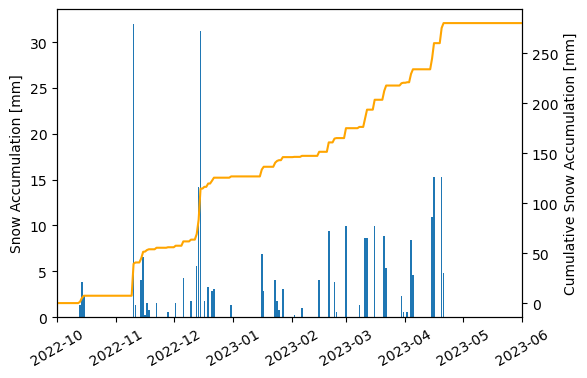

In [5]:
'''Open Canopy Snow_mm from GR'''
precip['Snow_mm'] = 25.4*(np.where(precip.Snow_in > 0.0, precip.P_in, 0)) #Convert in to mm

fig, ax = plt.subplots(1, 1, figsize = (6,4))
#Snow Inputs
ax.bar(precip.Date, precip.Snow_mm)
#Season Accumulation
ax2 = plt.twinx(ax)
ax2.plot(precip.Date, np.cumsum(precip.Snow_mm), color = 'orange')
plt.xlim('2022-10-01','2023-06-01')
plt.xlabel('Date')
ax.set_ylabel('Snow Accumulation [mm]')
ax2.set_ylabel('Cumulative Snow Accumulation [mm]')
ax.tick_params(axis='x', rotation=30)

## Snow Model

### Model Calculations

In [6]:
'''Calculate Under Canopy Accumulation Rates'''
stakes = ['S236', 'S213', 'S632', 'S200', 'S623', 'S211', 'S633', 'S235', 'S644', 'S646', 'S202', 'S201', 'S204', 'S631', 'S645', 'S212', 'S221', 'S635', 'S621', 'S232', 'S222', 'S223', 'S624', 'S625', 'S655', 'S205', 'S246', 'S643', 'S225', 'S203', 'S622', 'S255', 'S654', 'S636', 'S224', 'S603', 'S612', 'S254', 'S642', 'S233', 'S215', 'S613', 'S245', 'S614', 'S234', 'S634', 'S220', 'S243', 'S611', 'S226', 'S244']

modelledSnow = pd.DataFrame()

#Calculate Snow in under the canopy
for stake in stakes:
    #lai at the site
    lai = float(lai_df['OLS Prediction Ring 5'].loc[lai_df.Stake_ID == stake].values)

    #select relevant data
    temp = allSnow_df[allSnow_df.stakes == stake].reset_index(drop = True)

    #merge with snow data
    temp2 = pd.merge(temp, precip[['Date', 'Tmax_F', 'Tmin_F', 'Snow_mm']], right_on = 'Date', left_on = 'time', how = 'right')

    #Temperature conversions
    temp2['Tavg_F'] = (temp2.Tmax_F + temp2.Tmin_F)/2
    temp2['Tavg_C'] = (temp2.Tavg_F - 32)/1.8000

    #Estimate Accumulation -- done in mm
    temp2['LAI'] = lai
    temp2['CanopyDensity'] = 0.29*(1.9 + np.log(temp2.LAI))
    #temp2['Snow_mm_underCanopy'] = temp2.Snow_mm * [1 - ((0.144*np.log(lai))+0.223)]
    temp2['Snow_mm_underCanopy'] = temp2.Snow_mm * [1 - ((0.144*lai)+0.223)] #test non log transformed interception rate
    temp2['Interception_mm'] = temp2.Snow_mm - temp2.Snow_mm_underCanopy

    #Estimate melt -- done in cm 
    temp2['DDF'] = 0.292-0.164*temp2.CanopyDensity
    temp2['Melt_cm_potential'] = np.where(((temp2.Tavg_C > 0) & (temp2.Snow_mm == 0)), temp2.DDF*(temp2.Tavg_C - 0), 0)

    temp2['Snow_cm_underCanopy'] = temp2['Snow_mm_underCanopy']/10
    temp2['deltaSWE'] = temp2.Snow_cm_underCanopy - temp2.Melt_cm_potential
    temp2['SWE_cm'] = positive_cumsum(temp2.deltaSWE)
    temp2['Melt_cm_modelled'] = np.where(np.diff(temp2.SWE_cm, append = 0) < 0, -np.diff(temp2.SWE_cm, append = 0), 0)

    #reset stake label and site characteristics
    temp2['stakes'] = stake
    temp2['northing'] = temp.northing[0]
    temp2['easting'] = temp.easting[0]
    temp2['zones'] = temp.zones[0]
    temp2['aspect'] = temp.aspect[0]
    temp2['slope'] = temp.slope[0]
    temp2['watershed'] = temp.watershed[0]

    #concat
    modelledSnow = pd.concat([modelledSnow, temp2])

In [7]:
modelledSnow

,index,time,northing,easting,depths,zones,stakes,aspect,slope,watershed,...,LAI,CanopyDensity,Snow_mm_underCanopy,Interception_mm,DDF,Melt_cm_potential,Snow_cm_underCanopy,deltaSWE,SWE_cm,Melt_cm_modelled
0,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.150873,0.0,-4.150873,0.0,0.0
1,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.688949,0.0,-4.688949,0.0,0.0
2,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.765817,0.0,-4.765817,0.0,0.0
3,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.535213,0.0,-4.535213,0.0,0.0
4,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,1.306756,0.0,-1.306756,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,6.632449,0.0,-6.632449,0.0,0.0
299,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,5.839438,0.0,-5.839438,0.0,0.0
300,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,4.830153,0.0,-4.830153,0.0,0.0
301,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,4.613877,0.0,-4.613877,0.0,0.0


In [8]:
modelledSnow.to_csv('./Cleaned Data/snowModel_results2023.csv')

### Melt Calculations

In [9]:
'''Estimate Melt and Melt season from Measured SWE'''
SWE['Melt_cm'] = SWE.groupby('SITE')['SWE_cm'].diff().fillna(0)
SWE['Melt_cm'] = np.where(SWE.Melt_cm < 0, -SWE.Melt_cm, 0)

#Assign accumulation/melt season label
SWE['maxSWE_index'] = SWE.groupby('SITE')['SWE_cm'].transform('idxmax')
SWE['maxDATE'] = [SWE['DATE'][i] for i in SWE['maxSWE_index']]
SWE['Season'] = np.where(SWE.DATE < SWE.maxDATE, 'Accumulation', 'Melt')

SWE

,SITE,DATE,SWE_cm,Melt_cm,maxSWE_index,maxDATE,Season
0,S220,2023-01-13,3.556,0.0,349,2023-03-17,Accumulation
1,S215,2023-01-13,7.620,0.0,404,2023-03-24,Accumulation
2,S205,2023-01-13,5.080,0.0,405,2023-03-24,Accumulation
3,S204,2023-01-13,0.254,0.0,352,2023-03-17,Accumulation
4,S203,2023-01-13,8.128,0.0,461,2023-03-31,Accumulation
...,...,...,...,...,...,...,...
614,S621,2023-04-27,NaN,0.0,506,2023-03-31,Melt
615,S611,2023-04-27,NaN,0.0,345,2023-03-09,Melt
616,S612,2023-04-27,4.826,0.0,508,2023-03-31,Melt
617,S623,2023-04-27,11.430,0.0,455,2023-03-24,Melt


### Model Plots

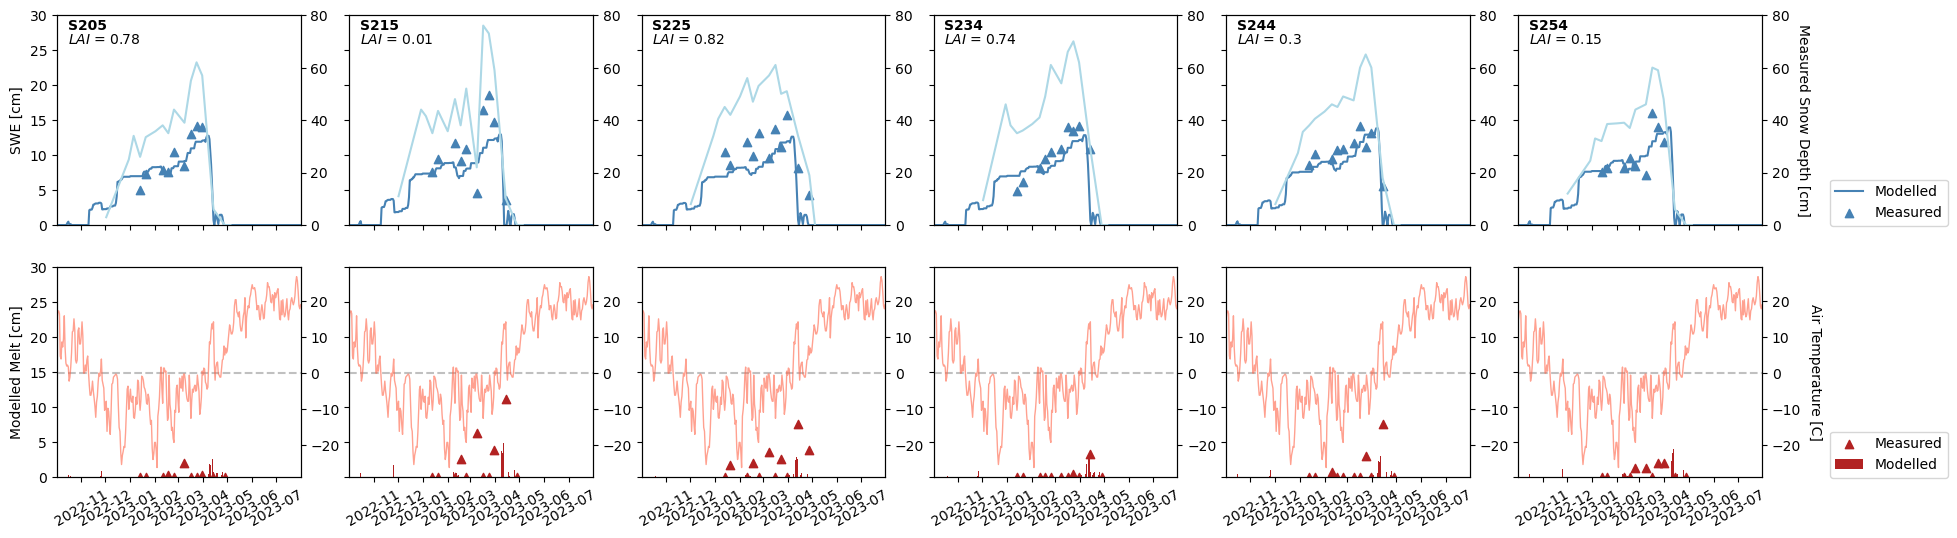

In [10]:
fig, axs = plt.subplots(2, 6, figsize = (22,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S205', 'S215', 'S225', 'S234', 'S244', 'S254']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'Modelled', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
   
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(datasubset.Date, datasubset.Tavg_C, color = 'tomato', alpha = 0.6, linewidth = 1)

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')

    elif(i == 5):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Air Temperature [C]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))

    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


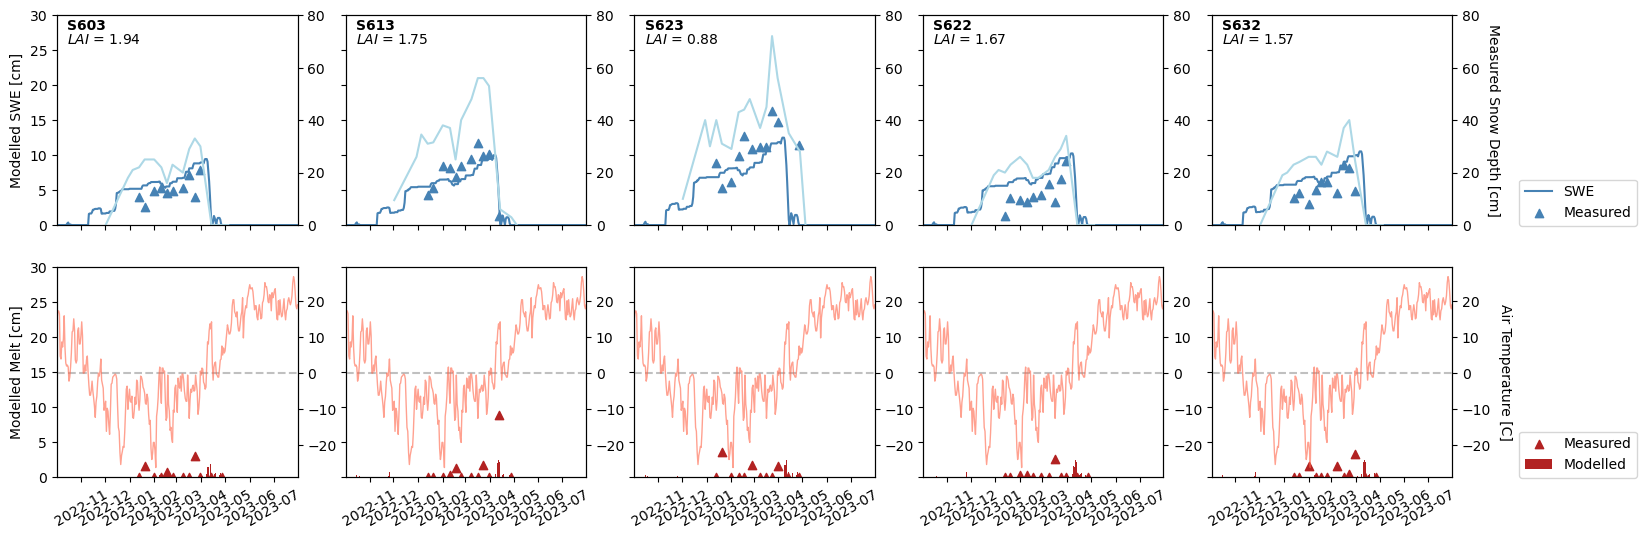

In [11]:
fig, axs = plt.subplots(2, 5, figsize = (18,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S603', 'S613', 'S623', 'S622', 'S632']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'SWE', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
    
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(datasubset.Date, datasubset.Tavg_C, color = 'tomato', alpha = 0.6, linewidth = 1)

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('Modelled SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')
    elif(i == 4):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Air Temperature [C]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))
    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


### Model Error Analysis

In [12]:
#Merge in measrued SWE data
modelledSnow_SWE = modelledSnow.merge(SWE, right_on = ['DATE', 'SITE'], left_on = ['Date', 'stakes'], how = 'outer')
modelledSnow_SWE = modelledSnow_SWE.rename(columns = {'SWE_cm_x' : 'SWE_cm_modelled', 
                         'SWE_cm_y' : 'SWE_cm_measured', 
                         'Melt_cm' : 'Melt_cm_measured'})

c:\Users\marie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Model - Measured SWE')

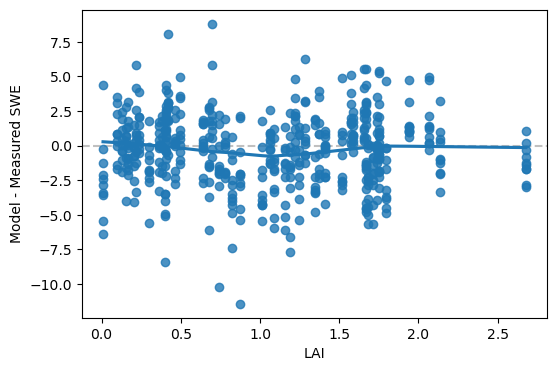

In [13]:
'''Model Error Analysis'''
fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.axhline(y = 0, xmin = 0, xmax = 2.5, linestyle = '--', color = 'silver', zorder = -2)
modelledSnow_SWE['modelError'] = modelledSnow_SWE.SWE_cm_modelled - modelledSnow_SWE.SWE_cm_measured
sns.regplot(modelledSnow_SWE.LAI, modelledSnow_SWE.modelError, 
            lowess = True, ax = ax)
ax.set_xlabel('LAI')
ax.set_ylabel('Model - Measured SWE')

Text(0, 0.5, 'Measured SWE')

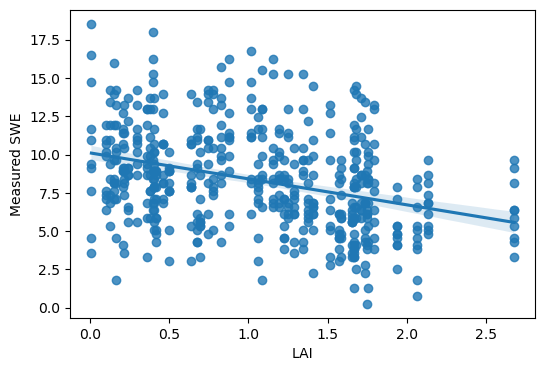

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (6,4))

sns.regplot(modelledSnow_SWE.LAI, modelledSnow_SWE.SWE_cm_measured,
            ax = ax)

ax.set_xlabel('LAI')
ax.set_ylabel('Measured SWE')

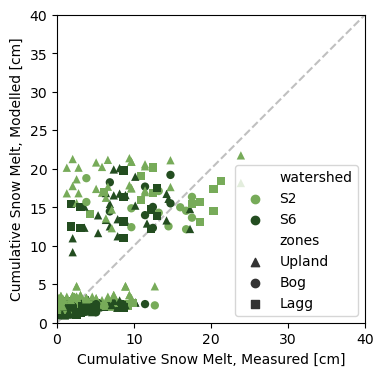

In [15]:
'''Cumulative estimated Melt'''
#Track cumulative melt
modelledSnow_SWE['Melt_cm_measured_cumsum'] = modelledSnow_SWE.groupby(['stakes'])['Melt_cm_measured'].cumsum()
modelledSnow_SWE['Melt_cm_modelled_cumsum'] = modelledSnow_SWE.groupby(['stakes'])['Melt_cm_modelled'].cumsum()

#Plot
fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.axline(xy1 = [0, 0], xy2 = [40, 40], linestyle = '--', color = 'silver', zorder = -5)
sns.scatterplot(data = modelledSnow_SWE, x = 'Melt_cm_measured_cumsum', y = 'Melt_cm_modelled_cumsum',
                hue = 'watershed', style = 'zones', 
                palette = {'S2': '#77ab59', 'S6': '#234d20'}, 
                linewidth = 0,
                markers = ['^', 'o', 's'])
ax.set_xlabel('Cumulative Snow Melt, Measured [cm]')
ax.set_ylabel('Cumulative Snow Melt, Modelled [cm]')
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_aspect('equal')
ax.legend()



## Melt Rate and Canopy Cover Analysis

c:\Users\marie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


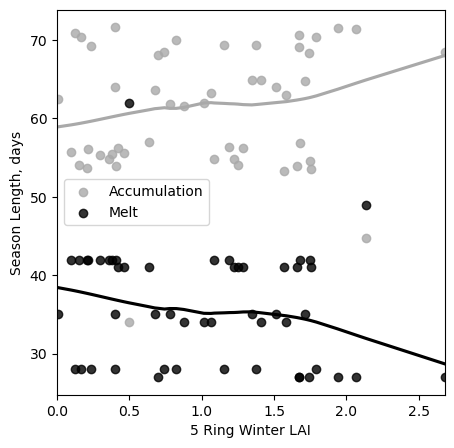

In [16]:
'''LAI/Melt Rate Comparison'''
#Find season lengths
SWE_rates = (SWE.groupby(['SITE', 'Season'])['DATE'].max() - SWE.groupby(['SITE', 'Season'])['DATE'].min()).reset_index(drop = False)
SWE_rates = SWE_rates.pivot_table("DATE", ["SITE"], "Season", aggfunc="first")
SWE_rates['Accumulation'] = SWE_rates.Accumulation.astype(str).str[0:2].astype(int)
SWE_rates['Melt'] = SWE_rates.Melt.astype(str).str[0:2].astype(int)

#Merge with LAI data
SWE_rates = SWE_rates.merge(lai_df[['Stake_ID', 'Zone', 'OLS Prediction Ring 5']], left_on = 'SITE', right_on = 'Stake_ID')

fig, ax = plt.subplots(1, 1, figsize = (5, 5))

sns.regplot(SWE_rates['OLS Prediction Ring 5'], SWE_rates['Accumulation'], 
            y_jitter = 2, color = 'darkgrey', label = 'Accumulation', 
            lowess = True)
sns.regplot(SWE_rates['OLS Prediction Ring 5'], SWE_rates['Melt'], 
            color = 'black', label = 'Melt', 
            lowess = True)

ax.set_xlim(0, max(SWE_rates['OLS Prediction Ring 5']))
ax.set_xlabel('5 Ring Winter LAI')
ax.set_ylabel('Season Length, days')
plt.legend()

plt.savefig('D:/1_DesktopBackup/Feng Research/0_MEF Snow Hydology/mef-snowhydro/Figures/snowPlots/meltRates.svg')

## SWE --> Soil Frost

### Data Import

In [17]:
'''Soil Frost vs. Melt'''
#Import Soil Frost Data
frost = pd.read_csv('./Cleaned Data/2023frost_data.csv', 
                        parse_dates = ['DATE'])

#Merge with SWE data
SWE = SWE.merge(frost[['STAKE NO', 'DATE', 'FROST.1']], right_on = ['STAKE NO', 'DATE'], left_on = ['SITE', 'DATE'])

In [18]:
'''Import Veg data to compare'''
veg = pd.read_csv("./Cleaned Data/VegData_LAI_Snow.csv")
veg.columns

Index(['Stake_ID', 'X', 'Zone', 'X..Sky.Area', 'X..Mask.Area', 'X..Cnpy.Open',
       'X..Site.Open', 'LAI.4Ring', 'LAI.5Ring', 'Watershed',
       'OLS.Prediction.Ring.4', 'WLS.Prediction.Ring.4',
       'OLS.Prediction.Ring.5', 'WLS.Prediction.Ring.5', 'Summer.LAI.4Ring',
       'Summer.LAI.5Ring', 'DIST_FT', 'DIST_M', 'DBH_IN', 'DBH_CM', 'n',
       'basalArea_m2', 'BIOMASS', 'Co', 'Dom', 'Int', 'Sup', 'prop_Deciduous',
       'prop_Coniferous', 'WATERSHED', 'avg_depths', 'max_depths'],
      dtype='object')

In [19]:
#Aggregate by stake -- merge with LAI
SWE_seasontotals = SWE.groupby('SITE')['Melt_cm'].sum()
SWE_seasonmax = SWE.groupby('SITE')['SWE_cm', 'FROST.1'].max()
SWE_agg = pd.merge(right = SWE_seasonmax, left = SWE_seasontotals, on = 'SITE').reset_index(drop = False)

#Merge with LAI
SWE_aggLAI = SWE_agg.merge(lai_df[['Stake_ID', 'Zone', 'OLS Prediction Ring 5']], right_on = 'Stake_ID', left_on = 'SITE')

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\1546081710.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SWE_seasonmax = SWE.groupby('SITE')['SWE_cm', 'FROST.1'].max()


In [20]:
#Export to csv
SWE_aggLAI.to_csv('./Cleaned Data/SWE_FROST_yearSummary.csv')

### Soil Frost Plots

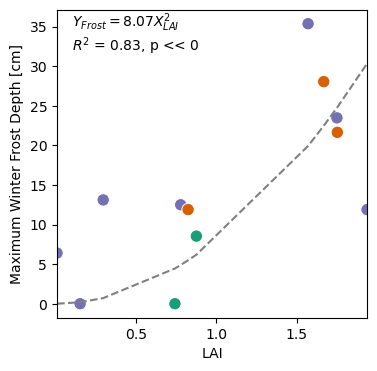

In [21]:
#Plot of Frost and LAI model with results from Rmd file
custom_pal = {'Upland': '#7570b3', 
              'Lagg': '#d95f02', 
              'Bog': '#1b9e77'}

fig, ax = plt.subplots(1, 1, figsize = (4,4))

sns.scatterplot(data = SWE_aggLAI, x = 'OLS Prediction Ring 5', y = 'FROST.1',
                hue = 'Zone', palette = custom_pal, 
                s = 80, 
                legend = False)
ax.plot(np.sort(SWE_aggLAI['OLS Prediction Ring 5']), pow(2.8404*np.sort(SWE_aggLAI['OLS Prediction Ring 5']), 2), 
        '--', color = 'grey')
ax.set_ylabel('Maximum Winter Frost Depth [cm]')
ax.set_xlabel('LAI')
ax.set_xlim(min(SWE_aggLAI['OLS Prediction Ring 5']), max(SWE_aggLAI['OLS Prediction Ring 5']))

#Text
ax.text(0.1, 35, r'$Y_{Frost} = 8.07 X_{LAI}^2$')
ax.text(0.1, 32, r'$R^2$ = 0.83, p << 0')

plt.savefig('../Figures/laiPlots/lai_frostDepth.svg')

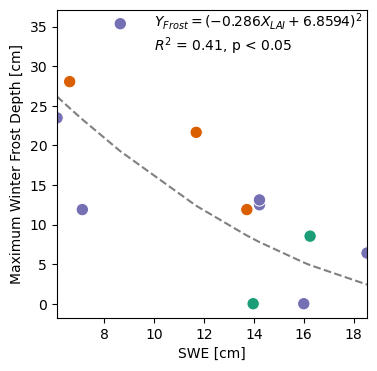

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (4,4))

sns.scatterplot(data = SWE_aggLAI, x = 'SWE_cm', y = 'FROST.1',
                hue = 'Zone', palette = custom_pal, 
                s = 80, 
                legend = False)
ax.plot(np.sort(SWE_aggLAI['SWE_cm']), pow(-0.2861*np.sort(SWE_aggLAI['SWE_cm']) + 6.8594, 2), 
        '--', color = 'grey')
ax.set_ylabel('Maximum Winter Frost Depth [cm]')
ax.set_xlabel('SWE [cm]')
ax.set_xlim(min(SWE_aggLAI['SWE_cm']), max(SWE_aggLAI['SWE_cm']))

#Text
ax.text(10, 35, r'$Y_{Frost} = (-0.286X_{LAI} + 6.8594)^2$')
ax.text(10, 32, r'$R^2$ = 0.41, p < 0.05')

plt.savefig('../Figures/laiPlots/swe_frostDepth.svg')


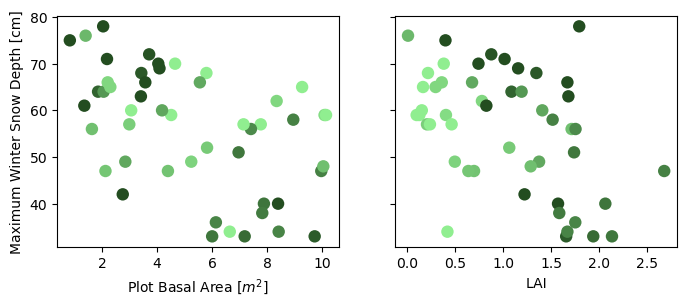

In [23]:
decCMAP = sns.color_palette("blend:#234d20,lightgreen", as_cmap=True)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (8, 3), 
                               sharey = True)

sns.scatterplot(data = veg, x = 'basalArea_m2', y = 'max_depths', ax = ax1, 
            hue = 'prop_Deciduous', legend = None, 
            palette = decCMAP, 
            linewidth = 0,
            s = 80)

sns.scatterplot(data = veg, x = 'OLS.Prediction.Ring.5', y = 'max_depths', ax = ax2, 
            hue = 'prop_Deciduous', legend = None,
            palette = decCMAP,
            linewidth = 0,
            s = 80)

ax1.set_ylabel("Maximum Winter Snow Depth [cm]")
ax1.set_xlabel(r"Plot Basal Area [$m^2$]")
ax2.set_xlabel('LAI')

plt.savefig('../Figures/Veg/snowBasalArea_python.svg', bbox_inches = 'tight')

## SWE--> Soil Moisture

### Import Soil Moisture Data

In [24]:
'''Import Data'''

soilM = pd.read_csv(import_path + '01_cleanedsensordata.csv', 
                    parse_dates = ['DateTime'],  
                    index_col = 'Unnamed: 0')

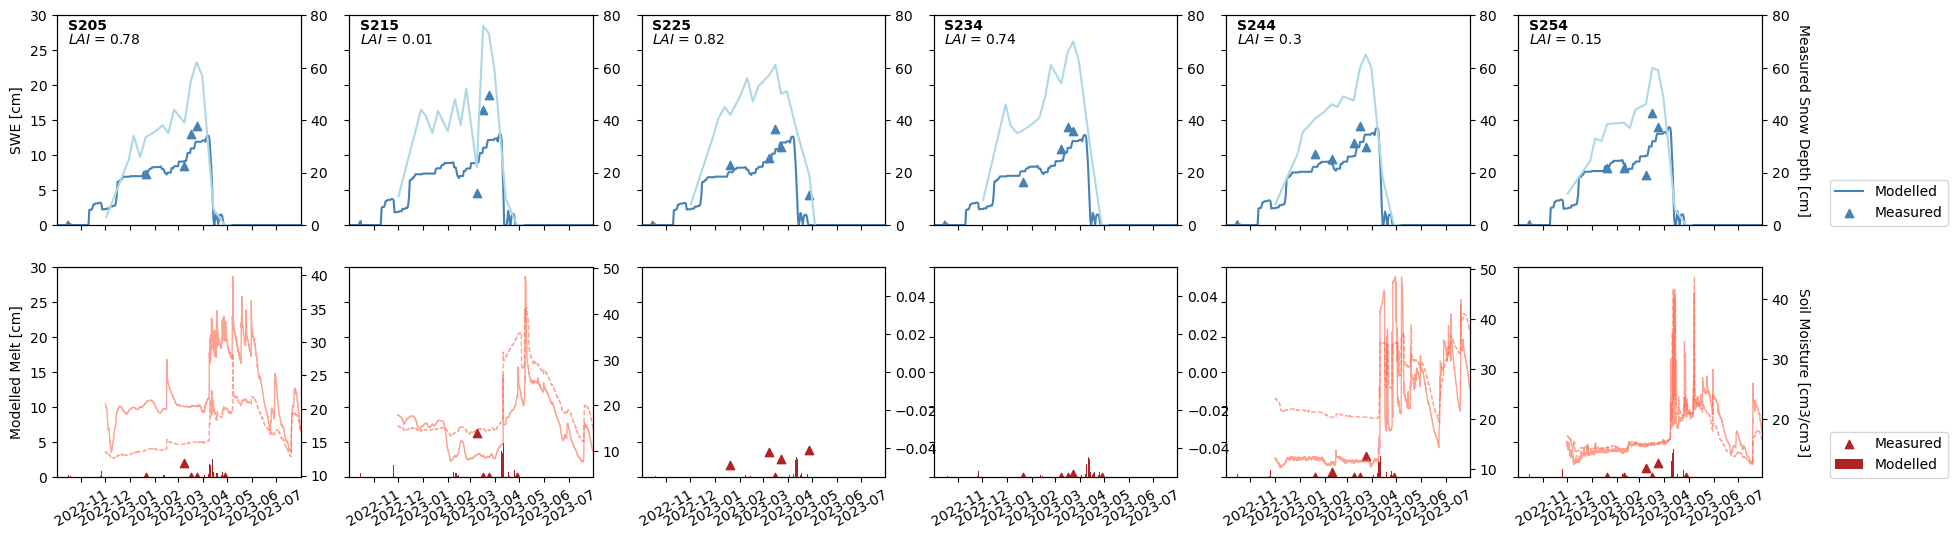

In [25]:
#Redo Model Plot with Soil Moisture in the top and middle layer
fig, axs = plt.subplots(2, 6, figsize = (22,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S205', 'S215', 'S225', 'S234', 'S244', 'S254']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    Soilsubset = soilM[soilM.SensorName == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'Modelled', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
   
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is soil M[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    #axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(Soilsubset.DateTime, Soilsubset.SoilMoist_15cm, color = 'tomato', alpha = 0.6, linewidth = 1)
    axs1_twin.plot(Soilsubset.DateTime, Soilsubset.SoilMoist_30cm, color = 'tomato', alpha = 0.6, linewidth = 1, linestyle = '--')

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')

    elif(i == 5):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Soil Moisture [cm3/cm3]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))

    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


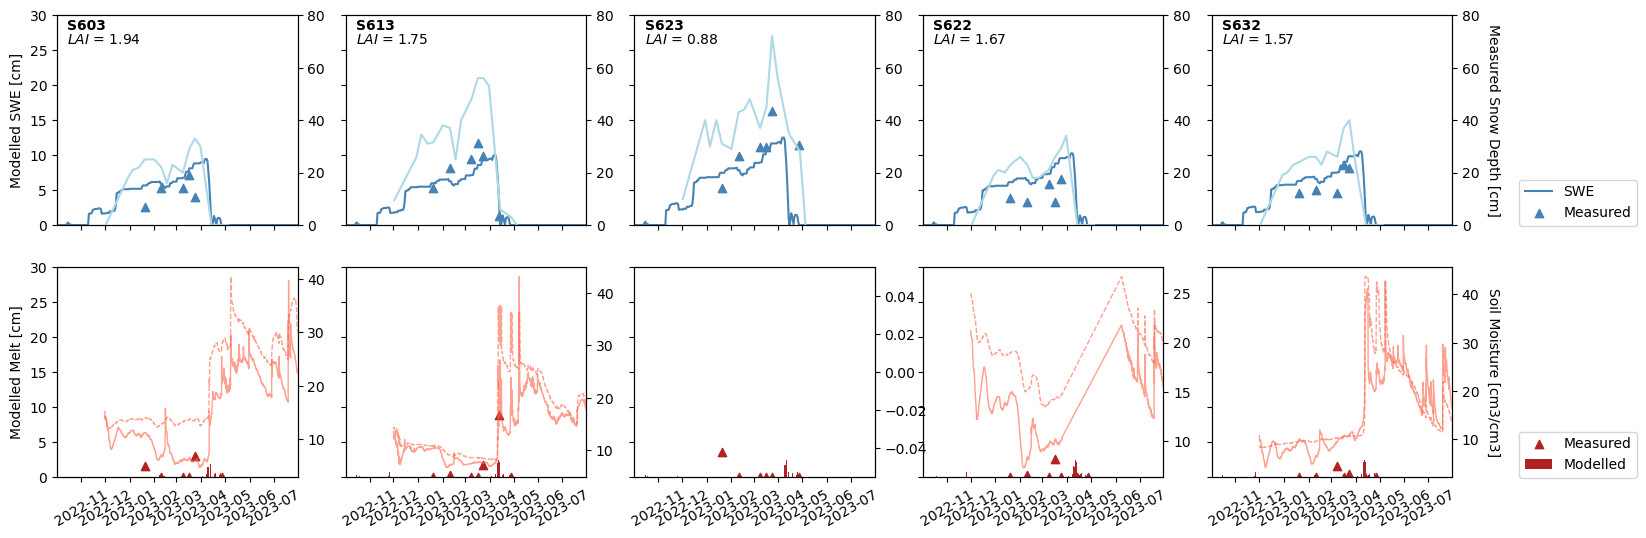

In [26]:
fig, axs = plt.subplots(2, 5, figsize = (18,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S603', 'S613', 'S623', 'S622', 'S632']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    Soilsubset = soilM[soilM.SensorName == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'SWE', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
    
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    #axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(Soilsubset.DateTime, Soilsubset.SoilMoist_15cm, color = 'tomato', alpha = 0.6, linewidth = 1)
    axs1_twin.plot(Soilsubset.DateTime, Soilsubset.SoilMoist_30cm, color = 'tomato', alpha = 0.6, linewidth = 1, linestyle = '--')

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('Modelled SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')
    elif(i == 4):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Soil Moisture [cm3/cm3]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))
    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


### Snowmelt and Soil Moisture Time Series Analysis

In [27]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import grangercausalitytests
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig_savepath = '../Figures/'

c:\Users\marie\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


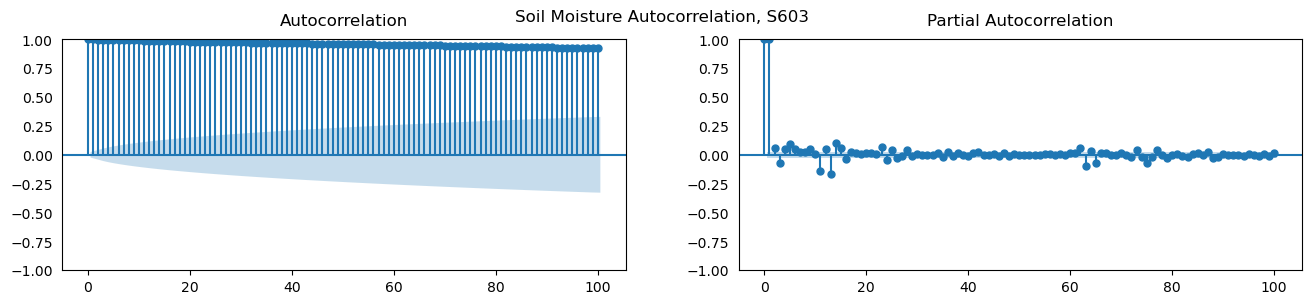

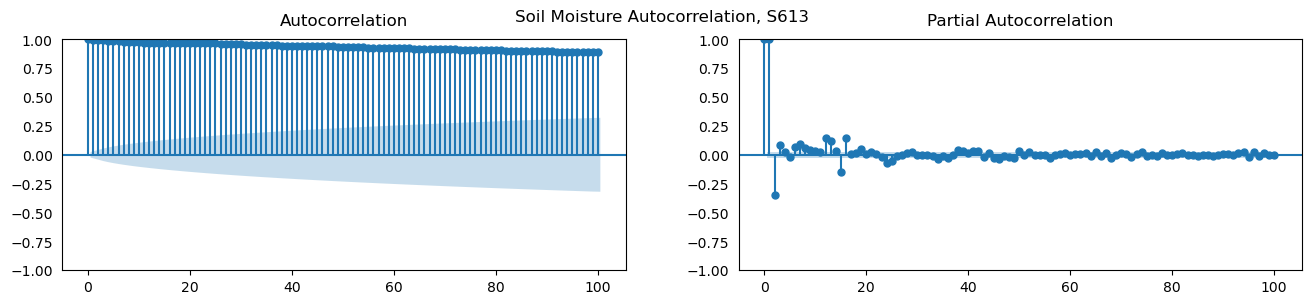

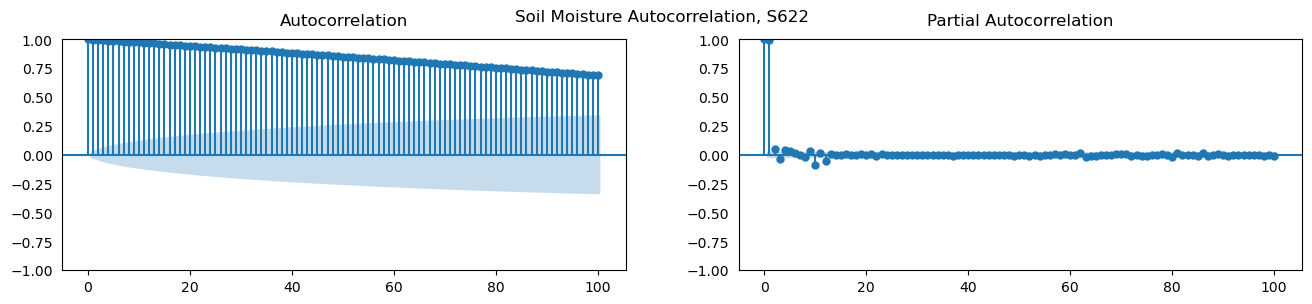

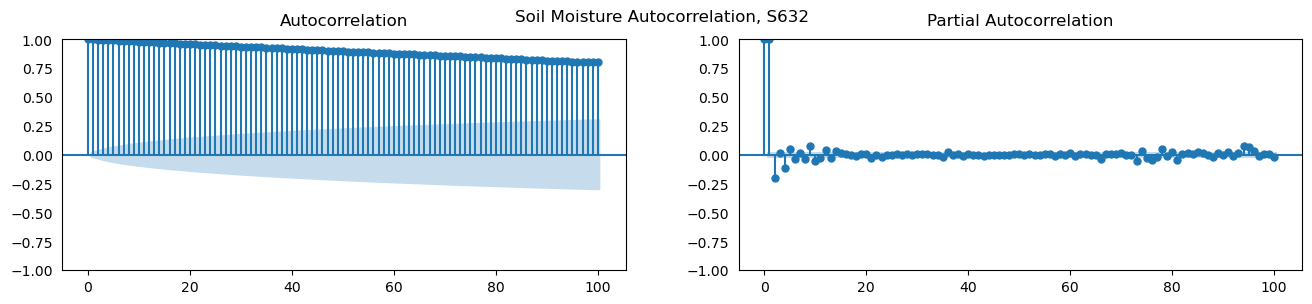

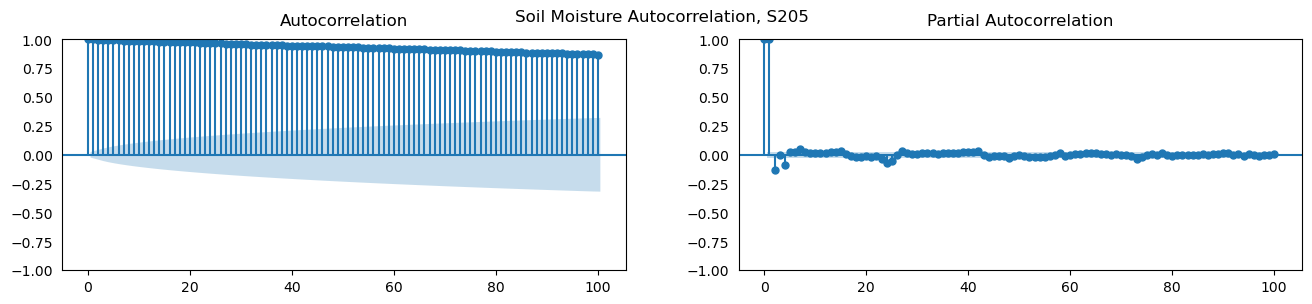

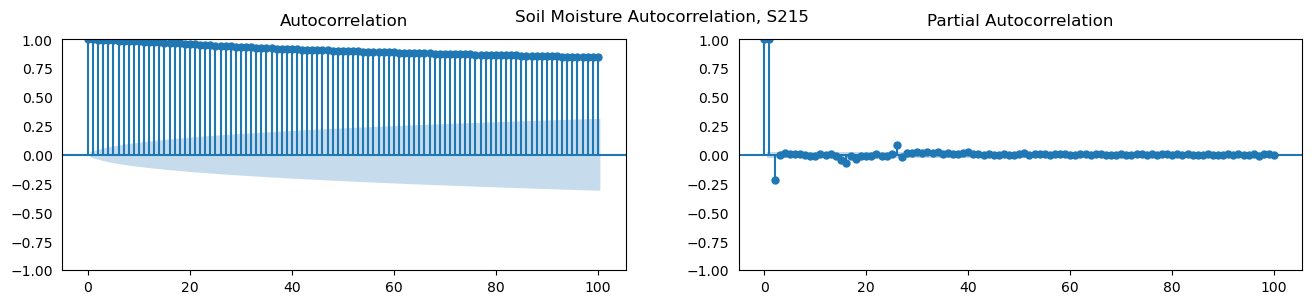

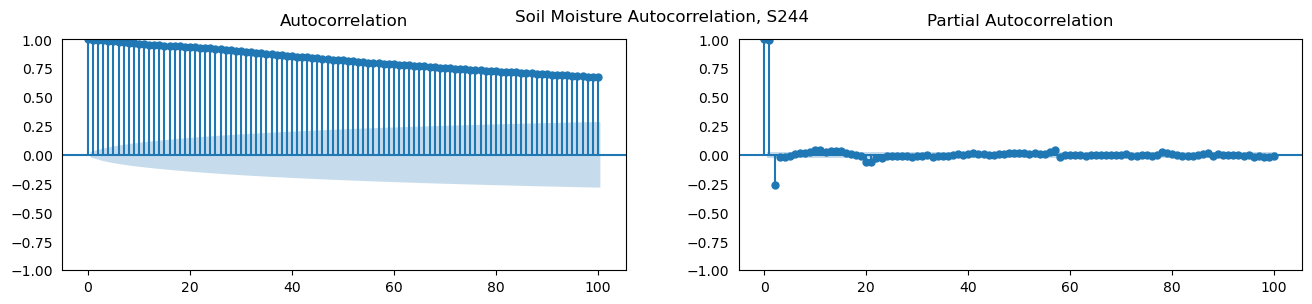

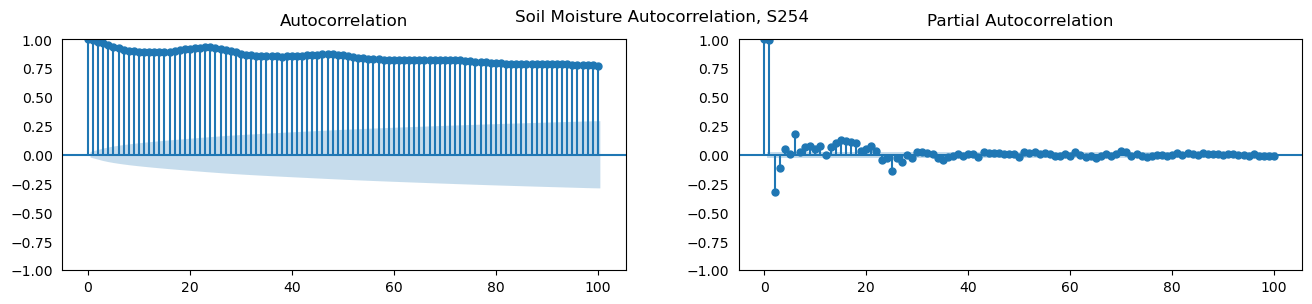

In [28]:
# Autocorrelation Plots
for site in ['S603', 'S613', 'S622', 'S632', 'S205', 'S215', 'S244', 'S254']:
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    a = plot_acf(soilM.SoilMoist_15cm[soilM.SensorName == site].tolist(), lags=100, ax=axes[0])
    b = plot_pacf(soilM.SoilMoist_15cm[soilM.SensorName == site].tolist(), lags=100, ax=axes[1])
    plt.suptitle('Soil Moisture Autocorrelation, ' + site)


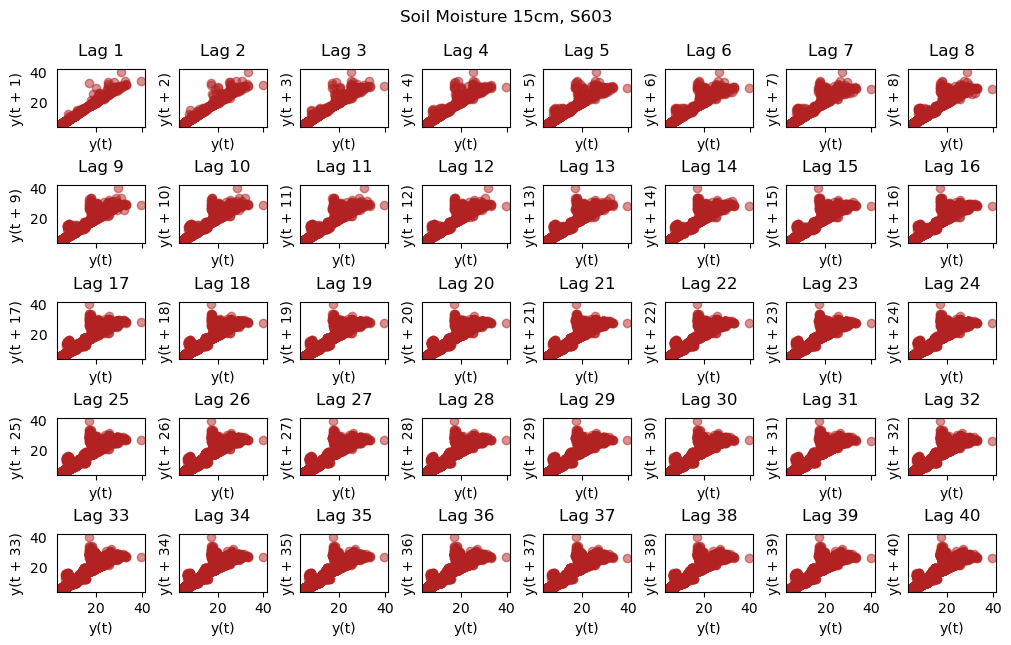

In [29]:
# Lag Plots
fig, axes = plt.subplots(5, 8, figsize=(10,6), sharex=True, sharey=True, dpi=100, 
                         constrained_layout = True)
for i, ax in enumerate(axes.flatten()[:40]):
    lag_plot(soilM.SoilMoist_15cm[soilM.SensorName == 'S603'], lag=i+1, ax=ax, c='firebrick', alpha = 0.5)
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Soil Moisture 15cm, S603', y=1.05)    
plt.show()

In [30]:
#Merge soil moisture and snowmelt data by date and site
soilMelt_data = pd.merge(soilM[['DateTime', 'SensorName', 'SoilMoist_15cm', 'SoilMoist_30cm', 'SoilMoist_45cm']],
                    modelledSnow_SWE[['Date', 'stakes', 'Melt_cm_modelled', 'Melt_cm_measured']],
                    left_on = ['DateTime', 'SensorName'], right_on = ['Date', 'stakes'], how = 'outer')

#Calculate deltaSoilM -- change in storage
soilMelt_data['dSoilMoist_15cm'] = soilMelt_data.SoilMoist_15cm.diff().fillna(0)
soilMelt_data['dSoilMoist_30cm'] = soilMelt_data.SoilMoist_30cm.diff().fillna(0)
soilMelt_data['dSoilMoist_45cm'] = soilMelt_data.SoilMoist_45cm.diff().fillna(0)

#Look only at the spring melt season
soilMelt_data = soilMelt_data[(soilMelt_data.Date.dt.year == 2023) & (soilMelt_data.Date.dt.month > 2)]



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8041  , p=0.0299  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=4.9008  , p=0.0268  , df=1
likelihood ratio test: chi2=4.8235  , p=0.0281  , df=1
parameter F test:         F=4.8041  , p=0.0299  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4909  , p=0.0128  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=9.2895  , p=0.0096  , df=2
likelihood ratio test: chi2=9.0149  , p=0.0110  , df=2
parameter F test:         F=4.4909  , p=0.0128  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3881  , p=0.0055  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=13.8087 , p=0.0032  , df=3
likelihood ratio test: chi2=13.2096 , p=0.0042  , df=3
parameter F test:         F=4.3881  , p=0.0055  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8643  , p=0.0256  

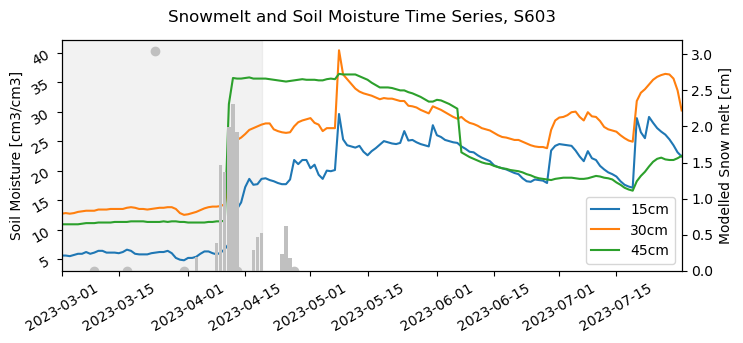

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


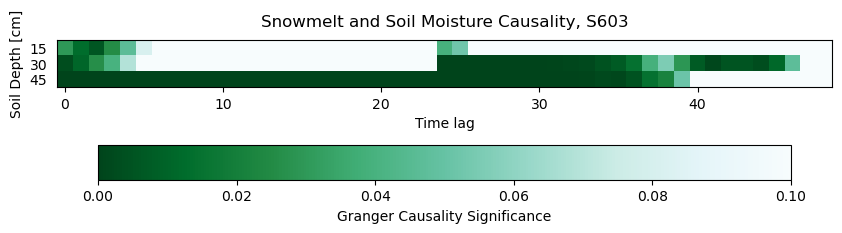


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7124  , p=0.1927  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=1.7469  , p=0.1863  , df=1
likelihood ratio test: chi2=1.7369  , p=0.1875  , df=1
parameter F test:         F=1.7124  , p=0.1927  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0662  , p=0.1304  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=4.2738  , p=0.1180  , df=2
likelihood ratio test: chi2=4.2145  , p=0.1216  , df=2
parameter F test:         F=2.0662  , p=0.1304  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1113  , p=0.1014  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=6.6439  , p=0.0842  , df=3
likelihood ratio test: chi2=6.5009  , p=0.0896  , df=3
parameter F test:         F=2.1113  , p=0.1014  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1753  , p=0.0749  

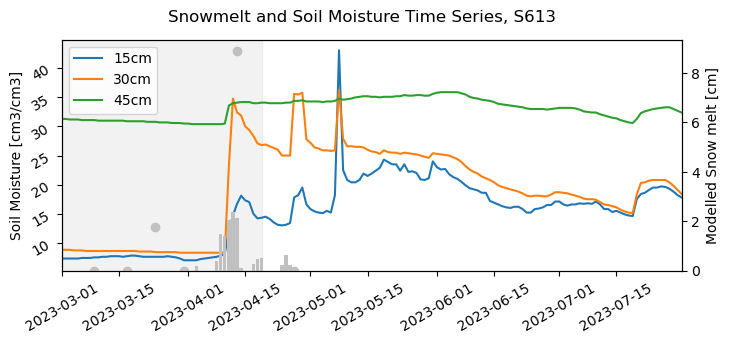

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


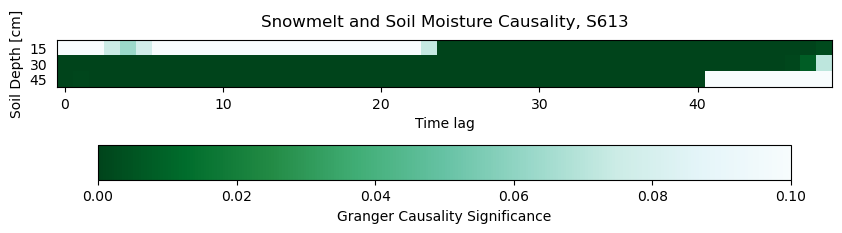


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.1868 , p=0.0000  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=30.7946 , p=0.0000  , df=1
likelihood ratio test: chi2=28.0414 , p=0.0000  , df=1
parameter F test:         F=30.1868 , p=0.0000  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.3380 , p=0.0000  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=35.8635 , p=0.0000  , df=2
likelihood ratio test: chi2=32.1779 , p=0.0000  , df=2
parameter F test:         F=17.3380 , p=0.0000  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.4453 , p=0.0000  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=39.1634 , p=0.0000  , df=3
likelihood ratio test: chi2=34.7964 , p=0.0000  , df=3
parameter F test:         F=12.4453 , p=0.0000  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.9076 , p=0.0000  

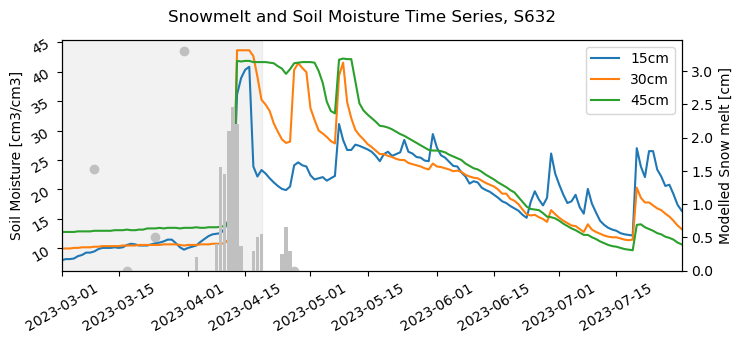

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


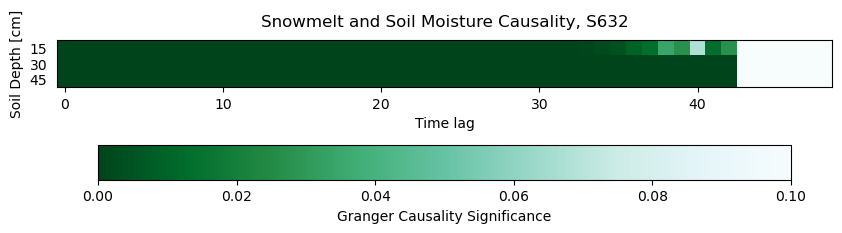


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5830  , p=0.2103  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=1.6149  , p=0.2038  , df=1
likelihood ratio test: chi2=1.6063  , p=0.2050  , df=1
parameter F test:         F=1.5830  , p=0.2103  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4121  , p=0.0932  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=4.9895  , p=0.0825  , df=2
likelihood ratio test: chi2=4.9088  , p=0.0859  , df=2
parameter F test:         F=2.4121  , p=0.0932  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7138  , p=0.1668  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=5.3932  , p=0.1452  , df=3
likelihood ratio test: chi2=5.2985  , p=0.1512  , df=3
parameter F test:         F=1.7138  , p=0.1668  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3051  , p=0.2711  

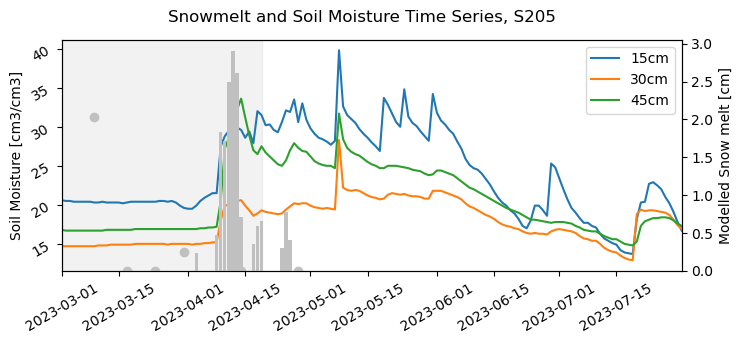

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


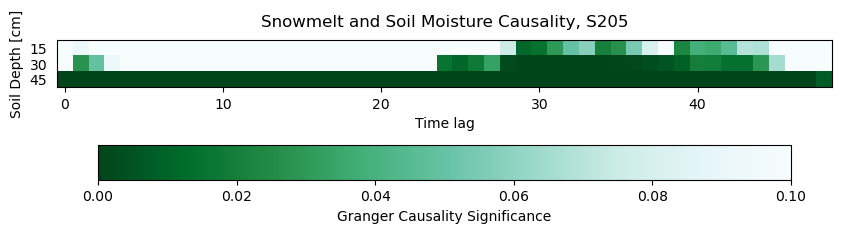


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3810  , p=0.5380  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.3887  , p=0.5330  , df=1
likelihood ratio test: chi2=0.3882  , p=0.5332  , df=1
parameter F test:         F=0.3810  , p=0.5380  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3957  , p=0.6739  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=0.8185  , p=0.6641  , df=2
likelihood ratio test: chi2=0.8163  , p=0.6649  , df=2
parameter F test:         F=0.3957  , p=0.6739  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0861  , p=0.3571  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=3.4178  , p=0.3316  , df=3
likelihood ratio test: chi2=3.3795  , p=0.3367  , df=3
parameter F test:         F=1.0861  , p=0.3571  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9398  , p=0.4429  

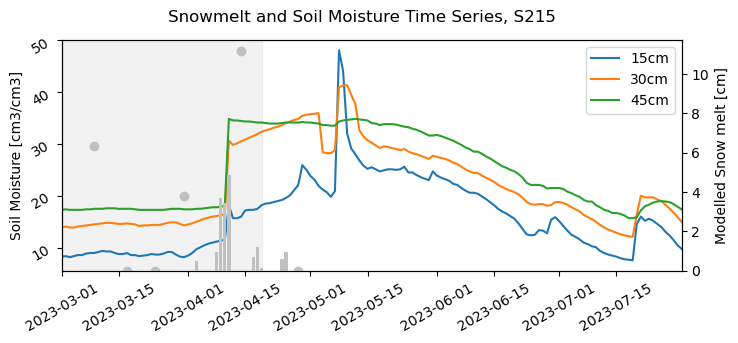

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


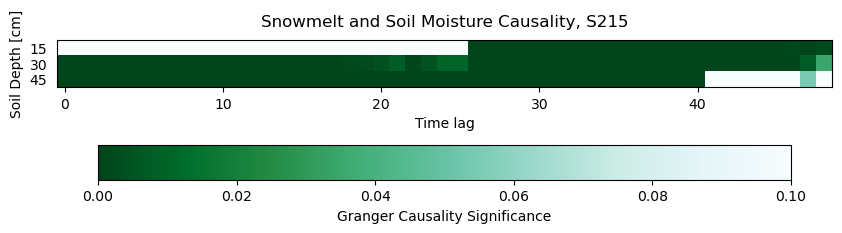


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5327 , p=0.0002  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=14.8253 , p=0.0001  , df=1
likelihood ratio test: chi2=14.1461 , p=0.0002  , df=1
parameter F test:         F=14.5327 , p=0.0002  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1500  , p=0.0027  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=12.7213 , p=0.0017  , df=2
likelihood ratio test: chi2=12.2138 , p=0.0022  , df=2
parameter F test:         F=6.1500  , p=0.0027  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4525  , p=0.0004  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=20.3052 , p=0.0001  , df=3
likelihood ratio test: chi2=19.0435 , p=0.0003  , df=3
parameter F test:         F=6.4525  , p=0.0004  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.1989  , p=0.0001  

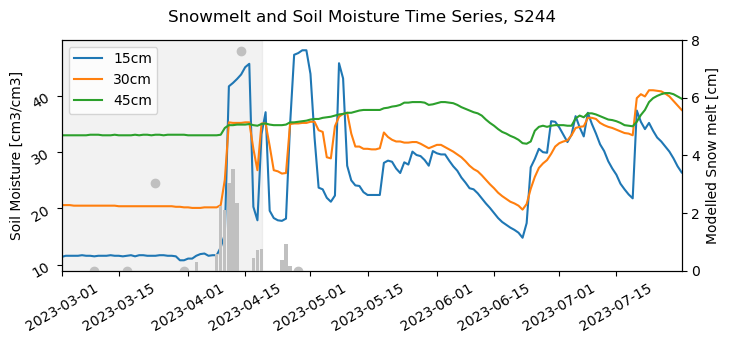

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


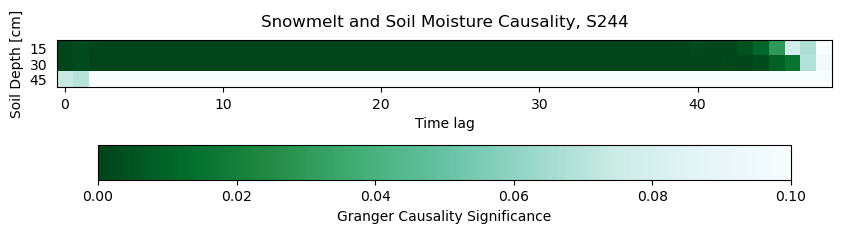


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4899  , p=0.4851  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.4998  , p=0.4796  , df=1
likelihood ratio test: chi2=0.4989  , p=0.4800  , df=1
parameter F test:         F=0.4899  , p=0.4851  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4042  , p=0.6682  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=0.8362  , p=0.6583  , df=2
likelihood ratio test: chi2=0.8338  , p=0.6591  , df=2
parameter F test:         F=0.4042  , p=0.6682  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6083  , p=0.6106  , df_denom=143, df_num=3
ssr based chi2 test:   chi2=1.9143  , p=0.5904  , df=3
likelihood ratio test: chi2=1.9022  , p=0.5930  , df=3
parameter F test:         F=0.6083  , p=0.6106  , df_denom=143, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4958  , p=0.7388  

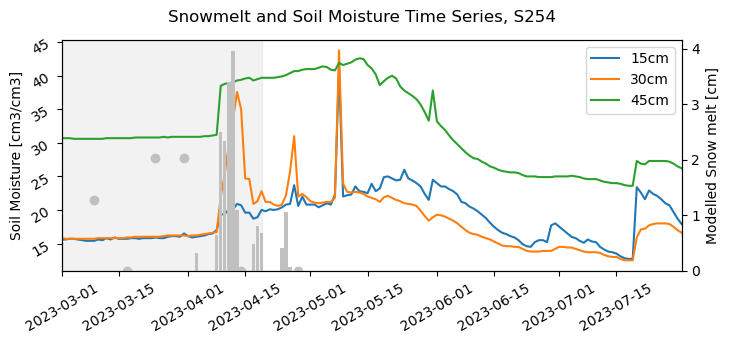

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2173633968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 15, 30, 45])


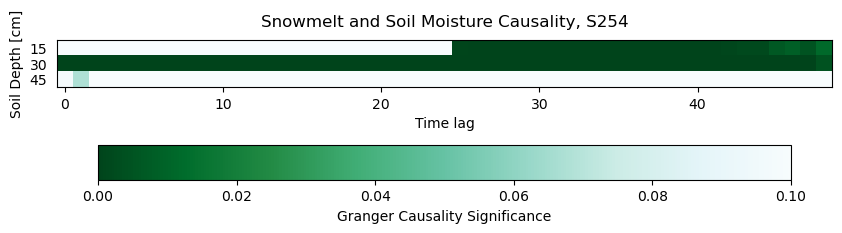

In [31]:
for site in ['S603', 'S613', 'S632', 'S205', 'S215', 'S244', 'S254']:
    #Run causality test
    lags = 49
    tempData = soilMelt_data[soilMelt_data.stakes == site]
    gcause_test15 = grangercausalitytests(tempData[['SoilMoist_15cm', 'Melt_cm_modelled']], maxlag=lags)
    gcause_test30 = grangercausalitytests(tempData[['SoilMoist_30cm', 'Melt_cm_modelled']], maxlag=lags)
    gcause_test45 = grangercausalitytests(tempData[['SoilMoist_45cm', 'Melt_cm_modelled']], maxlag=lags)

    #Manipuclate causality results into matrix for plotting
    resultsMat = np.zeros([3, lags])

    #Separate out depths
    for i in range(0, lags):
        resultsMat[0][i] = gcause_test15[i+1][0]['ssr_ftest'][1]
        resultsMat[1][i] = gcause_test30[i+1][0]['ssr_ftest'][1]
        resultsMat[2][i] = gcause_test45[i+1][0]['ssr_ftest'][1]

    #Plot Time Series
    fig, ax = plt.subplots(1, 1, figsize = (8, 3))

    ax.plot(tempData.DateTime, tempData.SoilMoist_15cm, label = '15cm')
    ax.plot(tempData.DateTime, tempData.SoilMoist_30cm, label = '30cm')
    ax.plot(tempData.DateTime, tempData.SoilMoist_45cm, label = '45cm')
    ax.axvspan(min(tempData.DateTime), min(tempData.DateTime) + dt.timedelta(lags), alpha=0.2, color='silver')
    ax.set_ylabel('Soil Moisture [cm3/cm3]')
    ax.set_xlim(min(tempData.DateTime), max(tempData.DateTime))
    ax.tick_params(rotation = 30)
    ax.legend()

    ax2 = plt.twinx(ax)
    ax2.bar(tempData.DateTime, tempData.Melt_cm_modelled, color = 'silver')
    ax2.scatter(tempData.DateTime, tempData.Melt_cm_measured, color = 'silver')
    ax2.set_ylabel('Modelled Snow melt [cm]')
    plt.suptitle('Snowmelt and Soil Moisture Time Series, ' + site)
    plt.savefig(fig_savepath + 'soilPlots/soilMoist_snowMelt/timeseries_' + site + '.pdf', bbox_inches = 'tight')
    plt.show()

    #Plot lag correlation matrix
    fig, ax = plt.subplots(1, 1, figsize = (10, 3))
    a = ax.matshow(resultsMat,
                cmap = 'BuGn_r', vmin = 0, vmax = 0.10)

    ax.set_xlabel('Time lag')
    ax.set_ylabel('Soil Depth [cm]')
    ax.set_yticklabels([0, 15, 30, 45])
    ax.xaxis.set_ticks_position('bottom')
    fig.colorbar(a, ax=ax, location = 'bottom', label = 'Granger Causality Significance', pad = 0.25)
    plt.title('Snowmelt and Soil Moisture Causality, ' + site)
    plt.savefig(fig_savepath + 'soilPlots/soilMoist_snowMelt/causality_' + site + '.pdf', bbox_inches = 'tight')
    plt.show()

### Site Specific Soil Analysis

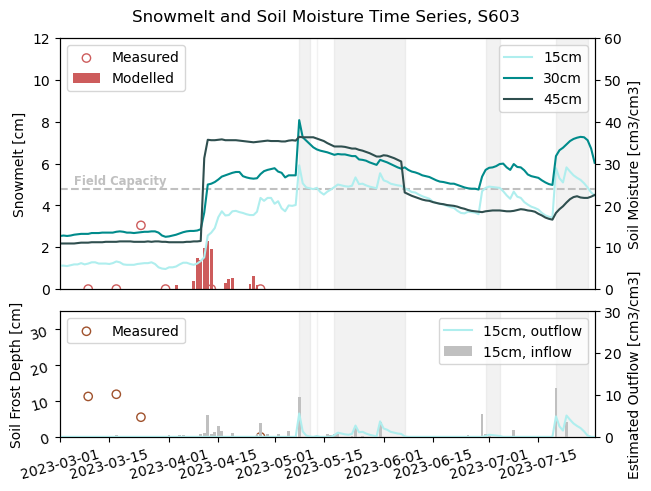

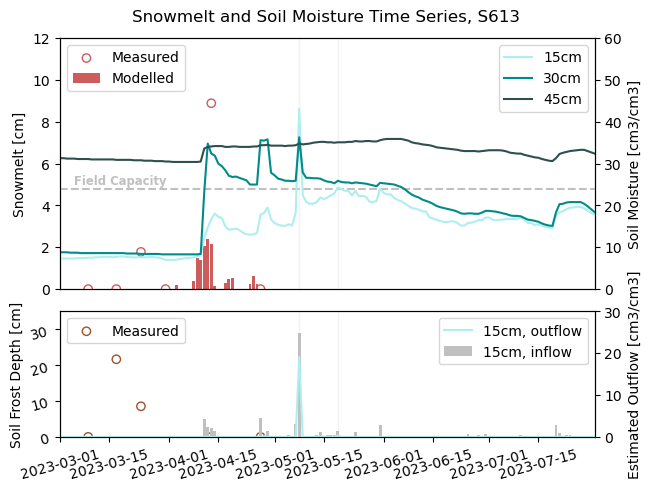

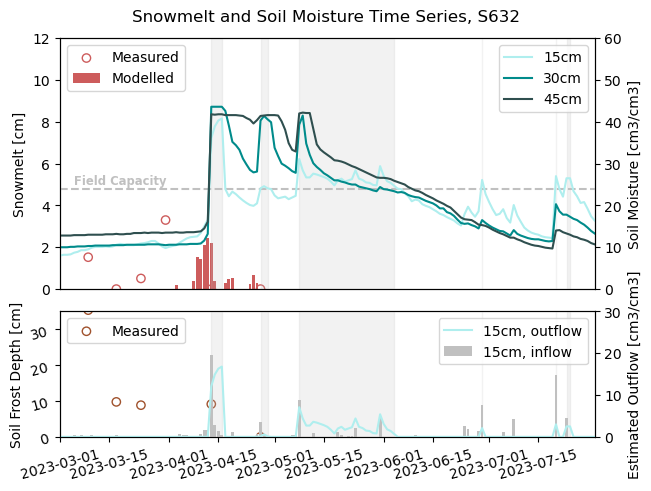

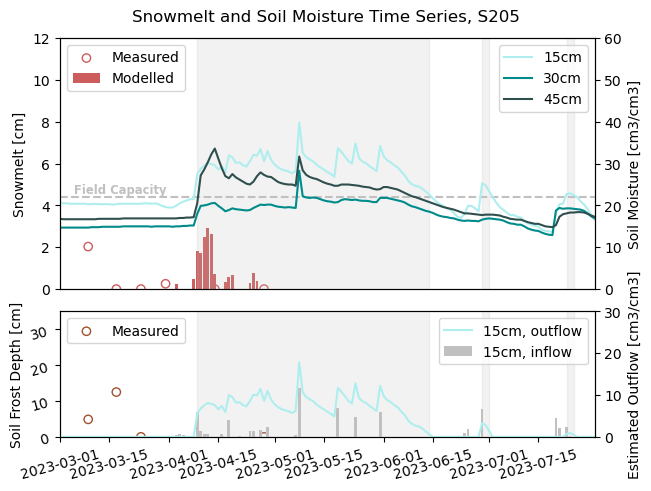

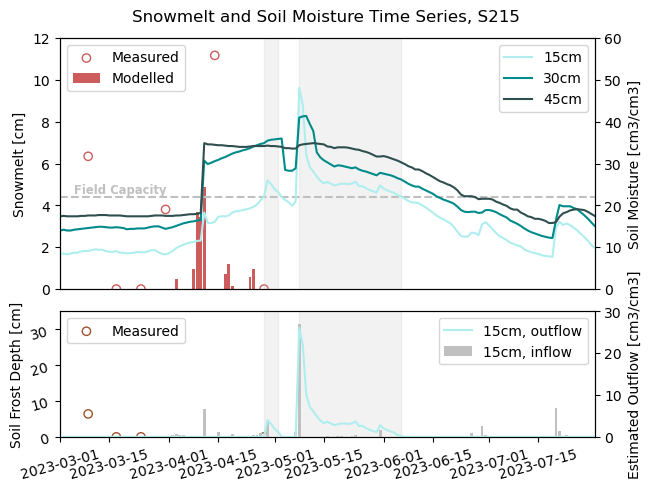

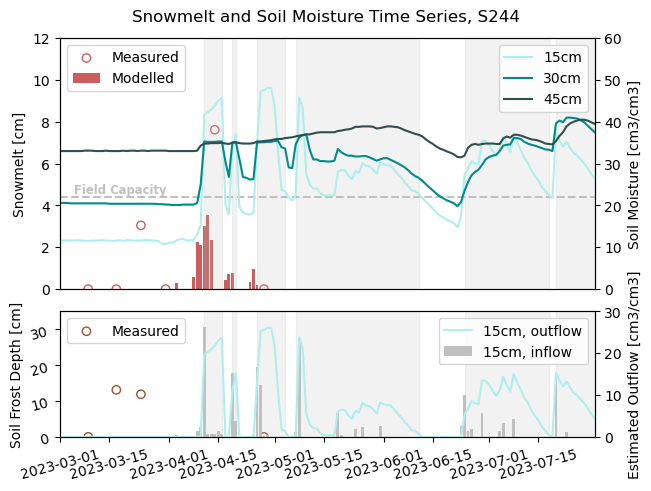

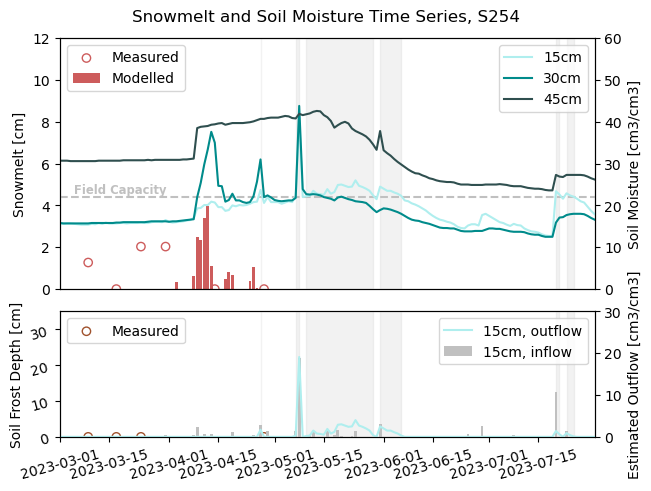

In [32]:
#Select site
for site in ['S603', 'S613', 'S632', 'S205', 'S215', 'S244', 'S254']:

    #Select field capacity 
    if site[0:2] == 'S2':
        fc = 22
    else:
        fc = 24

    tempData = soilMelt_data[soilMelt_data.stakes == site]
    tempFrost = frost[frost['STAKE NO'] == site]

    #merge
    tempData = tempData.merge(tempFrost, left_on = 'DateTime', right_on = 'DATE', how = 'outer')
    tempData['frost_depth'] = tempData['FROST.1'].fillna(method='ffill')

    fig = plt.figure(layout="constrained")
    gs = GridSpec(3, 1, figure=fig)

    #Top plot is soil moisture and melt -- shaded by field capacity
    ax1 = fig.add_subplot(gs[0:2, :])
    ax1.bar(tempData.DateTime, tempData.Melt_cm_modelled, color = 'indianred', label = 'Modelled')
    ax1.scatter(tempData.DateTime, tempData.Melt_cm_measured, color = 'indianred', marker = 'o', facecolor = 'none', label = 'Measured')
    ax1.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    ax1.set_ylim(0, 12)
    ax1.legend(loc = 'upper left')

    ax12 = plt.twinx(ax1)
    ax12.axhline(y = fc, zorder = -1, color = 'silver', linestyle = '--')
    ax12.fill_between(tempData.DateTime, 60, where = tempData.SoilMoist_15cm > fc, alpha=0.2, color='silver')
    ax12.text(pd.to_datetime('2023-03-05'), fc + 1, 'Field Capacity', color = 'silver', fontsize = 'small', fontweight = 'demi')
    ax12.plot(tempData.DateTime, tempData.SoilMoist_15cm, label = '15cm', color = 'paleturquoise')
    ax12.plot(tempData.DateTime, tempData.SoilMoist_30cm, label = '30cm', color = 'darkcyan')
    ax12.plot(tempData.DateTime, tempData.SoilMoist_45cm, label = '45cm', color = 'darkslategrey')
    ax12.set_ylabel('Soil Moisture [cm3/cm3]')
    ax12.set_xlim(min(tempData.DateTime), max(tempData.DateTime))
    ax12.set_ylim(0, 60)
    ax12.legend(loc = 'upper right')

    ax1.set_ylabel('Snowmelt [cm]')
    plt.suptitle('Snowmelt and Soil Moisture Time Series, ' + site)

    #Bottom plot is frost and estimated outflow
    ax2 = fig.add_subplot(gs[2, :])

    ax2.scatter(tempFrost.DATE, tempFrost['FROST.1'], color = 'sienna', marker = 'o', facecolor = 'none', label = 'Measured')
    ax2.tick_params(rotation = 15)
    ax2.set_ylim(0, 35)
    ax2.set_ylabel('Soil Frost Depth [cm]')
    ax2.legend(loc = 'upper left')
    
    ax22 = plt.twinx(ax2)
    #Calculate estimated inflow
    inflow15 = np.diff(tempData.SoilMoist_15cm, prepend = np.nan)
    ax22.bar(tempData.DateTime, inflow15, color = 'silver', label = '15cm, inflow')
    #Calculate estimated outflow
    outflow15 = np.where((tempData.SoilMoist_15cm - fc) > 0, (tempData.SoilMoist_15cm - fc), 0)
    ax22.plot(tempData.DateTime, outflow15, color = 'paleturquoise', label = '15cm, outflow')
    ax22.fill_between(tempData.DateTime, 60, where = tempData.SoilMoist_15cm > fc, alpha=0.2, color='silver')


    # outflow30 = np.where((tempData.SoilMoist_30cm - fc) > 0, (tempData.SoilMoist_30cm - fc), 0)
    # ax22.plot(tempData.DateTime, outflow30, color = 'darkcyan', label = '30cm')
    # outflow45 = np.where((tempData.SoilMoist_45cm - fc) > 0, (tempData.SoilMoist_45cm - fc), 0)
    # ax22.plot(tempData.DateTime, outflow45, color = 'darkslategrey', label = '45cm')
    ax22.set_xlim(min(tempData.DateTime), max(tempData.DateTime))
    ax22.set_ylim(0, 30)
    ax22.set_ylabel('Estimated Outflow [cm3/cm3]')
    ax22.legend(loc = 'upper right')

    plt.savefig(fig_savepath + 'soilPlots/soilMoist_snowMelt/fieldCapacity_' + site + '.pdf', bbox_inches = 'tight')
    plt.show()

### Timing and Amount

In [33]:
def spikeDetect(dat, var, windowBegin, windowEnd):
    #Description - This function takes in the entire vector of water table levels, soil moisture levels, etc. and returns the best 
    #   fit beginning and end to the snow melt signal
    #Packages - numpy (np), pandas (pd), seaborn (sns), matplotlib.pyplot (plt), 
    #   scipy.signal (find_peaks), scipy.stats (kendalltau) 
    #Input - dat: an mxn pandas dataframe containing at least three columns: 
    #               The variable of interest 'var'
    #               "DOY" containing the day of the year 
    #               "YEAR" containing the year of the data point
    #        var: the variable of interest in the dataframe 
    #        windowBegin: the date of the year of the begining of the spring season
    #        windowEnd: the date of the year of the end of the spring season
    #Outputs - WTETri: 6xN dataframe with the following format ['YEAR', WTE', 'Peak', 'Trough', 
    #                                                           'LengthClimb', 'HeightClimb']
    #        - One plot as detailed below
    #        - text ouputs detailing the peaks, troughs and their correlations
    
    Tri = dat[[var, 'YEAR']].groupby('YEAR', as_index = False).mean()
    
    Tri["Peak"] = list(range(0, len(Tri.YEAR)))
    Tri["Trough"] = list(range(0, len(Tri.YEAR)))
    Tri["LengthClimb"] = list(range(0, len(Tri.YEAR)))
    Tri["HeightClimb"] = list(range(0, len(Tri.YEAR)))
    
    Tri["PeakVar"] = list(range(0, len(Tri.YEAR)))
    Tri["TroughVar"] = list(range(0, len(Tri.YEAR)))
    
    for i in Tri.YEAR:
        
        print("-----\n")
         
        #Subset the data for the year of interest
        year = dat[var][dat.YEAR == i].reset_index(drop = True)
            
        print("Year: " + str(i) + "\n")

        #Subset the timeseries to the period of interest
        season = dat[var][(dat.DOY > windowBegin) & (dat.DOY < windowEnd)]
        
        #Calculated the percentiles for limiting peaks and trough selection        
        per5 = np.percentile(season, 10)
        per95 = np.percentile(season, 90)
        
        print("Seasonal Statistics")
        print("95th Percentile: " + str(per95))
        print("50th Percentile: " + str(np.mean(season)))
        print("5th Percentile: " + str(per5) + "\n")
        
        #Identify peaks during the selected time of the year and above the threshold
        peaks, _ = find_peaks(season, height = per95)
        #peaks = peaks + 30
        
        print("Peaks: " + str(peaks) + "\n")
        
        #Identify troughs during the selected time of year and below the threshold
        troughs, _ = find_peaks(-season, height = -per5)
        #troughs = troughs + 30
        
        print("Throughs: " + str(troughs) + "\n")
        
        #Create the matrix to hold the correlation coefficients
        coefficients = pd.DataFrame(np.zeros((len(troughs), len(peaks))))
        
        #Cycle through the rows (troughs) and columns (peaks)
        for index, row in coefficients.iterrows():
            t = troughs[index]
            
            for j in np.arange(0, len(peaks)):
                p = peaks[j]
                
                #print("Peak: " + str(p) + "   Trough: " + str(t))
                
                #Pull the real data and generate modeled data (straight line)
                real = year[t:p]
                step_size = (year[p]-year[t])/(len(real))
                model = np.arange(year[t], year[p], step_size)
                
                #For some reason a few years end up with unequal lengths
                if len(model) != len(real):
                    continue
                
                #Compare using the correlation coefficient
                coeff, _ = kendalltau(model, real, nan_policy = 'omit')
                
                #print("Kendall Tau: " + str(coeff) + "\n")
        
                row[j] = coeff
            
        #Pull out the highest correlation from the matrix, assign based on indices
        best = coefficients.max().max()
        best_t, best_p = list(np.where(coefficients == best))
        best_peak = peaks[best_p]
        best_trough = troughs[best_t]
        
        #PLOT: Shows the water table plot for that year overlayed with the 
        #   identified peaks and troughs
        fig = plt.gcf()
        fig.set_size_inches(6, 3)
        plt.plot(dat[dat.YEAR == i][var])
        plt.axvspan(min(season.index), max(season.index), color = 'b', alpha = 0.25, lw = 0)
        plt.plot(peaks, season[peaks], 'og')
        plt.plot(troughs, season[troughs], 'or')
        plt.plot(best_trough, season[best_trough], 'oy')
        plt.plot(best_peak, season[best_peak], 'oy')
        plt.title("Daily Change in " + var + ', ' + str(i))
        plt.show()


        #Assign all the values back to the dataframe
        Tri.loc[Tri.YEAR == i, 'Peak'] = best_peak
        Tri.loc[Tri.YEAR == i, 'Trough'] = best_trough
        Tri.loc[Tri.YEAR == i, 'LengthClimb'] = (best_peak - best_trough)
        Tri.loc[Tri.YEAR == i, 'HeightClimb'] = float(year[best_peak]) - float(year[best_trough])
        
        Tri.loc[Tri.YEAR == i, 'PeakVar'] = float(year[best_peak])
        Tri.loc[Tri.YEAR == i, 'TroughVar'] = float(year[best_trough])
        
        print("Best Peak: " + str(best_peak) + "   Best Trough: " + str(best_trough) + "\n")   
    
    return Tri

-----

Year: 2023

Seasonal Statistics
95th Percentile: 24.5
50th Percentile: 13.840470095415402
5th Percentile: 5.9

Peaks: [2776 3048 3052 3062 3083 3136 3267 3271 3276 3280 3287 3291 3297 3305
 3313 3317 3333 3335 3338 3344 3352 3370 3377 3380 3388 3406 3411 3417
 3422 3426 3428 3430 3475 3488 3497 3519 3530 3596 3598 3604 3607 3633
 3637 3648 3660 3687 3696 3699 3702 3708 3712 3726 3728 3733 3735 3737
 4292]

Throughs: [1363 1408 1457 1475 1529 1579 1866 1913 2105 2127 2176 2197 2323 2341]



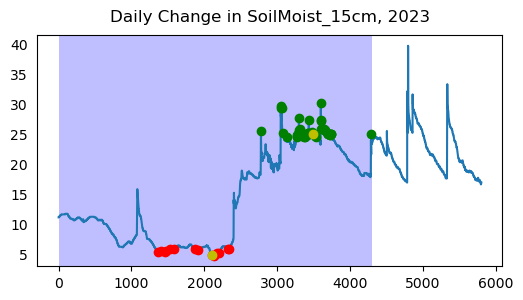

Best Peak: [3488]   Best Trough: [2105]

-----

Year: 2023

Seasonal Statistics
95th Percentile: 21.9
50th Percentile: 12.90051198510587
5th Percentile: 7.3

Peaks: [2439 2442 2463 2486 2510 2800 3033 3048 3069 3075 3184 3189 3192 3196
 3198 3202 3204 3213 3221 3226 3234 3239 3244 3246 3251 3254 3259 3263
 3268 3271 3274 3281 3283 3287 3298 3306 3317 3382 3384 3396 3398 3402
 3404 3416 3433 3438 3446 3450 3455 3457 3461 3467 3474 3478 3486 3489
 3502 3504 3598 3620 3638 3667 3672 3681 3689 3695 3697]

Throughs: [ 821  881 1000 1389 1520 2148 2150 2154]



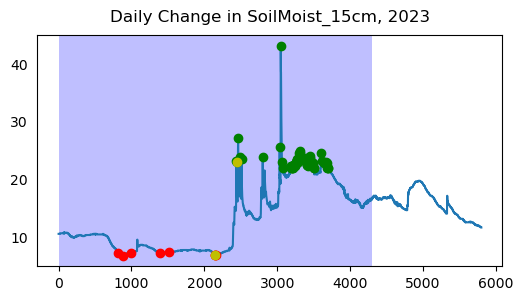

Best Peak: [2442]   Best Trough: [2150]

-----

Year: 2023

Seasonal Statistics
95th Percentile: 26.2
50th Percentile: 15.475861266294231
5th Percentile: 7.7

Peaks: [2470 2473 2490 2511 3046 3051 3093 3102 3106 3111 3117 3122 3131 3135
 3137 3139 3146 3159 3177 3181 3187 3190 3193 3197 3208 3217 3222 3226
 3229 3232 3235 3243 3246 3296 3318 3325 3330 3334 3340 3344 3348 3405
 3414 3429 3450 3455 3457 3472 3474 3476 3594 3597 4285 4292]

Throughs: [ 139  145  154  162  166  179  208  839  990 1366]



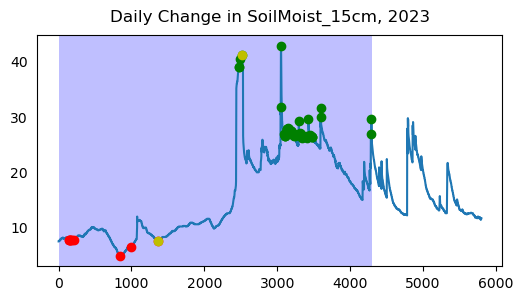

Best Peak: [2511]   Best Trough: [1366]

-----

Year: 2023

Seasonal Statistics
95th Percentile: 30.8
50th Percentile: 23.824255121043056
5th Percentile: 19.8

Peaks: [2393 2413 2416 2437 2440 2460 2509 2563 2581 2584 2606 2730 2752 2773
 2781 2783 2827 2831 2838 3031 3047 3051 3087 3094 3111 3117 3134 3298
 3306 3316 3350 3431 3469 3475 3594 3597 3617 3620 3658]

Throughs: [ 869 2131 2145 2155 2176 2182 2189 2209 4085 4145 4168 4173 4225 4277]



C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2295565378.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  step_size = (year[p]-year[t])/(len(real))


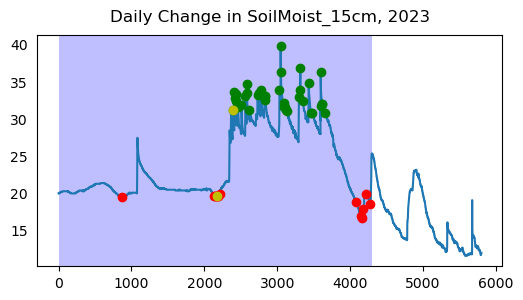

Best Peak: [2393]   Best Trough: [2176]

-----

Year: 2023

Seasonal Statistics
95th Percentile: 24.9
50th Percentile: 15.743971135940333
5th Percentile: 8.6

Peaks: [2395 2827 2833 2844 3033 3050 3134 3140 3142 3156 3172 3180 3184 3236
 3255 3281 3296 3304 3316 3326 3354 3378 3403 3405 3408 3430 3448 3456
 3597]

Throughs: [ 831 1357 1463 1862 2127]



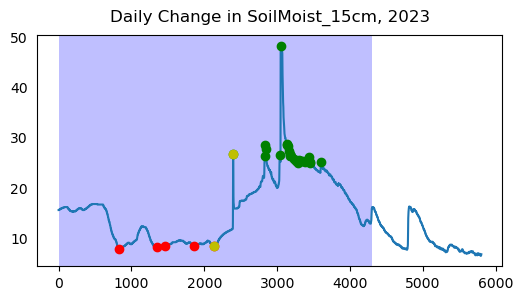

Best Peak: [2395]   Best Trough: [2127]

-----

Year: 2023

Seasonal Statistics
95th Percentile: 30.2
50th Percentile: 18.76992551210418
5th Percentile: 11.3

Peaks: [2392 2406 2468 2520 2587 2612 2755 2775 2810 2850 2856 2874 2896 3033
 3059 3061 3317 3482 3596 4193 4205 4216 4232 4292]

Throughs: [ 741  755  777  809  826  852  894  920  923  928  932  936  950  968
  976  985 1010 1012 1016 1039 1043 1046 1055 1058 1062 1069 1334 1367
 1386 1389 1422 1553 1620 2081 2094 2102 2109 2121 2127 2139 2144 2150
 2173 2200]



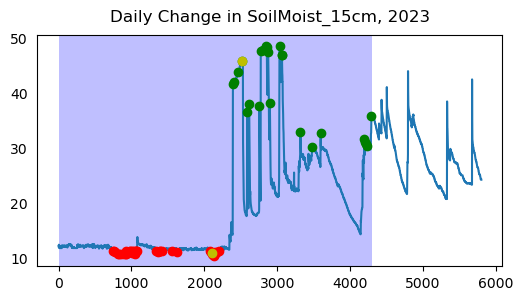

Best Peak: [2520]   Best Trough: [2102]

-----

Year: 2023

Seasonal Statistics
95th Percentile: 23.2
50th Percentile: 17.82080521293926
5th Percentile: 14.6

Peaks: [2417 2441 2465 2752 2781 2784 2831 3023 3029 3048 3051 3115 3138 3146
 3152 3154 3163 3241 3267 3280 3284 3296 3305 3308 3317 3323 3330 3334
 3345 3348 3353 3355 3358 3364 3373 3381 3383 3393 3396 3408 3410 3414
 3426 3430 3457 3460 3474 3478 3483 3485 3493 3500 3512 3528 3530 3536
 3597 3603 3608 3643 3656 3659 3670 3693 3699]

Throughs: [   3   15   20   26   36   41   55   64   68   75   80   87   99  103
  127  133  137  140  147  156  160  168  174  182  196  205  212  220
  223  230  237  242  260  267  274  285  290  311  331  338  344  351
  355  367  374  380  390  399  406  410  427  437  446  454  463  469
  476  493  501  508  512  516  523  529  543  550  561  574  583  601
  607  616  632  641  645  660  674  686  695  704  711  769  773  791
  829  846  858  884  901  918  929  938  943  958  977  991 1008 

C:\Users\marie\AppData\Local\Temp\ipykernel_7376\2295565378.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  step_size = (year[p]-year[t])/(len(real))


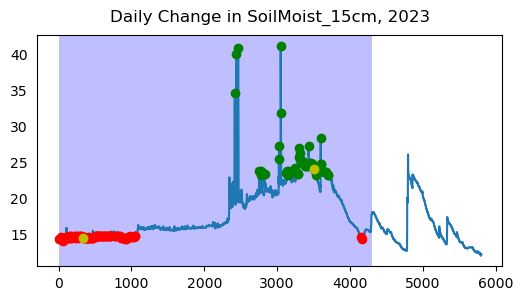

Best Peak: [3512]   Best Trough: [338]



In [34]:
#Detect Soil Moisture Peaks and Throughs
for site in ['S603', 'S613', 'S632', 'S205', 'S215', 'S244', 'S254']:
    #Prep data - 15cm moisture
    moistDat = soilM[(soilM.SensorName == site) & (soilM.DateTime.dt.year == 2023)][['SoilMoist_15cm', 'DateTime']].reset_index(drop = True)
    moistDat['YEAR'] = moistDat.DateTime.dt.year
    moistDat['DOY'] = moistDat.DateTime.dt.day_of_year

    #Run
    spikeDetect(moistDat, 'SoilMoist_15cm', 0, 180)